In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats as st
from scipy.stats import norm
import statsmodels.api as sm
import math
import random
import re

# Обзор scipy.stats

In [2]:
norm()

In [3]:
rv = norm()

In [4]:
dir(norm)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_argcheck',
 '_argcheck_rvs',
 '_attach_argparser_methods',
 '_attach_methods',
 '_cdf',
 '_cdf_single',
 '_cdfvec',
 '_construct_argparser',
 '_construct_default_doc',
 '_construct_doc',
 '_ctor_param',
 '_entropy',
 '_fit_loc_scale_support',
 '_fitstart',
 '_get_support',
 '_isf',
 '_logcdf',
 '_logpdf',
 '_logsf',
 '_mom0_sc',
 '_mom1_sc',
 '_mom_integ0',
 '_mom_integ1',
 '_moment_error',
 '_munp',
 '_nnlf',
 '_nnlf_and_penalty',
 '_open_support_mask',
 '_parse_arg_template',
 '_parse_args',
 '_parse_args_rvs',
 '_parse_args_stats',
 '_pdf',
 '_penalized_nnlf',
 '_ppf',
 

In [5]:
dist_continu = [d for d in dir(st) if
                isinstance(getattr(st, d), st.rv_continuous)]
dist_discrete = [d for d in dir(st) if
                 isinstance(getattr(st, d), st.rv_discrete)]
print('Количество непрерывных распределений: %d' % len(dist_continu))
print('Количество дискретных распределений:   %d' % len(dist_discrete))

Количество непрерывных распределений: 104
Количество дискретных распределений:   19


In [6]:
norm.cdf(0)

0.5

Можем вывести для нескольких точек.

In [7]:
norm.cdf([-1., 0, 1])

array([0.15865525, 0.5       , 0.84134475])

Если хотим получить CDF и PDF некоторого распределения:

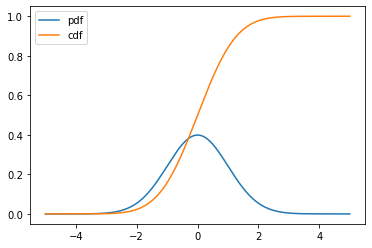

In [8]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

y_pdf = norm.pdf(x, mu, sigma) # pdf нормального распределения
y_cdf = norm.cdf(x, mu, sigma) # cdf нормального распределения

plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend();

Можем исследовать как параметры расрпделения влияют на его вид:

In [9]:
def plot_normal(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    x = x_range
    if cdf:
        y = norm.cdf(x, mu, sigma)
    else:
        y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)

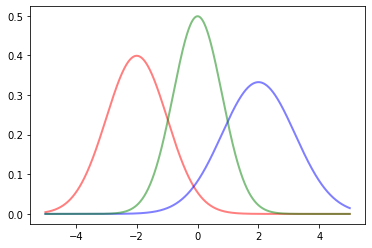

In [10]:
plot_normal(x, -2, 1, color='red', lw=2, ls='-', alpha=0.5)
plot_normal(x, 2, 1.2, color='blue', lw=2, ls='-', alpha=0.5)
plot_normal(x, 0, 0.8, color='green', lw=2, ls='-', alpha=0.5);

Создадим и исследуем выборку из заданного распределения:

In [11]:
from scipy.stats import beta

# для воспроизводимости
np.random.seed(seed=233423)

a, b = 2, 6

x = beta.rvs(a, b, size=1000)

In [12]:
x.mean()

0.24882674925049722

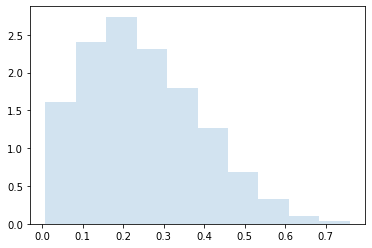

In [13]:
fig, ax = plt.subplots(1, 1)
ax.hist(x, density=True, histtype='stepfilled', alpha=0.2)
plt.show()

Выведем статистику распределения:

In [14]:
m = beta.mean(a,b)
v = beta.var(a,b)
shp_a = beta.a
shp_b = beta.b
median = beta.median(a,b)

rv_stats = {"mean": m, "var": v, "shape a": shp_a, "shape b": shp_b, "median": median}
_ = [print(k,":",f'{v:.3f}') for k,v in rv_stats.items()]

mean : 0.250
var : 0.021
shape a : 0.000
shape b : 1.000
median : 0.228


Первые 4 момента:

In [15]:
moments_values = beta.stats(a,b, moments="mvsk")

moments_names = ["mean", "var", "skew", "kurt"]
moments = dict(zip(moments_names, moments_values))
_ = [print(k,":",f'{v:.3f}') for k,v in moments.items()]

mean : 0.250
var : 0.021
skew : 0.693
kurt : 0.109


# Подгонка распределения к данным

Предположим, мы хотим некоторое распределение к нашим наблюдениям. Для этого можем попробовать зафитить несколько разных распределений и посмотреть, какое лучше всего описывает наши данные.

In [26]:
def doane_formula(data):
    """
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def plot_histogram(data, results, n):
    # N первых распределений в ранжировании
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    # Гистограмма данных
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')
    
    # Распределения
    for distribution, result in N_DISTRIBUTIONS.items():
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        dist_name = re.search(r'_continuous_distns\.(.*?) object', str(distribution)).group(1)
        plt.plot(x_plot, y_plot, label=dist_name + ": " + str(sse)[0:6], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ALL_DISTRIBUTIONS = [d for d in dir(st) if
                isinstance(getattr(st, d), st.rv_continuous)]
    
    MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm, 
                        st.uniform, st.johnsonsb, st.gennorm,
                        st.gausshyper]

    # Ищем оптимальное количество бинов в гистограмме по формуле Доани
    num_bins = doane_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        # Получаем параметры распределения
        params = distribution.fit(data)
        
        # Выделяем нужные нам части параметров
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        # Рассчитываем подогнанный PDF и погрешность подгонки распределения 
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        # Считаем сумму квадратов ошибки
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        # Собираем результаты
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

Набор данных содержит океанографические и приземные метеорологические данные, полученные с ряда буев, расположенных по всей экваториальной части Тихого океана:
https://archive.ics.uci.edu/ml/datasets/El+Nino  

Данные собраны за несколько лет, колонки - это месяца. Потому перед анализом нам надо трансформировать набор данных.

In [27]:
df = sm.datasets.elnino.load_pandas().data.set_index('YEAR')

In [28]:
df

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73


In [29]:
data = pd.Series(df.values.ravel())

In [30]:
results = fit_data(data)

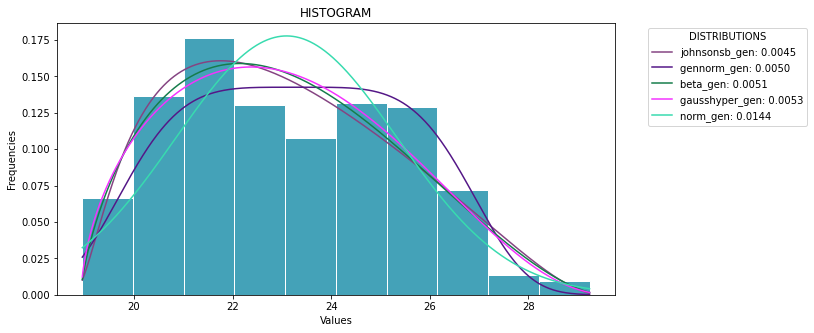

In [32]:
plot_histogram(data, results, 5)

# Z-test

In [16]:
from statsmodels.stats.weightstats import ztest  

## На одной выборке

Сгенерируем случайный массив из 50 чисел, имеющих среднее значение 110 и стандартное отклонение 15 аналогично данным IQ, которые мы предполагаем в задаче.

In [ ]:
mean_iq = 110
sd_iq = 15 / math.sqrt(50)
alpha = 0.05
null_mean = 100
# генерируем данные
data = np.random.randn(50) + mean_iq

In [22]:
print('mean=%.2f stdv=%.2f' % (np.mean(data), np.std(data)))
  

mean=109.94 stdv=0.93


Теперь проводим тест. В этой функции мы передали данные, в параметре значения мы передали среднее значение в нулевой гипотезе, в альтернативной гипотезе мы проверяем, больше ли среднее значение

In [23]:
ztest_Score, p_value = ztest(data, value = null_mean, alternative='larger')

In [24]:
ztest_Score, p_value

(74.5938069638874, 0.0)

Функция выводит p_value и z-score, соответствующие этому значению, мы сравниваем p-значение с альфа, если оно больше альфа, то мы не принимаем нулевую гипотезу, иначе мы ее отклоняем.

In [124]:
if(p_value <  alpha):
    print("Отклонить Н0.")
else:
    print("Н0 не может быть отклонена.")

Отклонить Н0.


## На двух выборках

Сравним уровни IQ в двух разных городах.

In [33]:
cityA = [82, 84, 85, 89, 91, 91, 92, 94, 99, 99,
         105, 109, 109, 109, 110, 112, 112, 113, 114, 114]

cityB = [90, 91, 91, 91, 95, 95, 99, 99, 108, 109,
         109, 114, 115, 116, 117, 117, 128, 129, 130, 133]

Выполняем тест.

value : float  
    In the one sample case, value is the mean of x1 under the Null
    hypothesis.
    In the two sample case, value is the difference between mean of x1 and
    mean of x2 under the Null hypothesis. The test statistic is
    `x1_mean - x2_mean - value`.

In [34]:
ztest(cityA, cityB, value=0) 

(-1.9953236073282115, 0.046007596761332065)

Статистика для двух выборок z-критерия составляет -1.9953, а соответствующее p-value равно 0.0460.

Поскольку p-value < 0.05, у нас есть достаточно доказательств, чтобы отвергнуть нулевую гипотезу. Другими словами, средний уровень IQ значительно различается между двумя городами.